<a href="https://colab.research.google.com/github/farhan1503001/Brain-Tumor-Classification/blob/master/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import h5py
import numpy as np
import os
import cv2
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [0]:
x_dataset=[]
y_dataset=[]
for i in range(len(os.listdir("/content/drive/My Drive/Brain Tumor type dataset"))):
    file=h5py.File("/content/drive/My Drive/Brain Tumor type dataset/"+str(i+1)+".mat",mode='r')
    Dataset=file["cjdata/image"]
    Label=file["cjdata/label"]
    x=np.array(Dataset,dtype='float32')
    y=np.array(Label,dtype='float32')
    x=scaler.fit_transform(x)
    x=np.repeat(x[:,:,np.newaxis],3,axis=2)
    x=cv2.resize(x,(224,224))
    x_dataset.append(x)
    y_dataset.append(y)
    print(i)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
X_dataset=np.array(x_dataset)
Y_dataset=np.array(y_dataset)
Y_dataset=Y_dataset.reshape((3064,1))

Y_dataset=Y_dataset-1

In [0]:
from sklearn.model_selection import KFold
folds=list(KFold(n_splits=5,shuffle=True,random_state=1).split(X_dataset,Y_dataset))

In [0]:
Inception=tf.keras.applications.InceptionV3(include_top=False,input_shape=(224,224,3))
input_image=tf.keras.layers.Input((224,224,3))
x=Inception (input_image)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(3)(x)
out=tf.keras.layers.Activation(activation='softmax')(x)

model=tf.keras.Model(inputs=input_image,outputs=out)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [0]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc,roc_curve

In [0]:
History=[]
Prescore=[]
Recall=[]
F1=[]
Sensspeci=[]
Roc_auc=[]
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))
    
    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_val,y_val))
    y_predict=model.predict(x_val)
    Y_predict=np.argmax(y_predict,axis=1)
    l=len(y_val)
    Y_predict=np.reshape(Y_predict,(l,1))
    prescore=precision_score(y_val,Y_predict,average=None)
    recaller=recall_score(y_val,Y_predict,average=None)
    score=f1_score(y_val,Y_predict,average=None)
    sensitivity=sensitivity_specificity_support(y_val,Y_predict,average=None)
    lb=label_binarize(y_val,classes=[0,1,2])
    lb1=label_binarize(Y_predict,classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(lb[:, i], lb1[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("Precision: ",prescore)
    print("Recall: ",recaller)
    print("F1-score ",score)
    print("Sensitivity ",sensitivity)
    History.append(history)
    Prescore.append(prescore)
    F1.append(score)
    Recall.append(recaller)
    Sensspeci.append(sensitivity)
    Roc_auc.append(roc_auc)

Fold 1
Train on 2451 samples, validate on 613 samples
Epoch 1/10
2451/2451 [==============================] - 34s 14ms/sample - loss: 0.4484 - acc: 0.8490 - val_loss: 0.6023 - val_acc: 0.7977
Epoch 2/10
2451/2451 [==============================] - 15s 6ms/sample - loss: 0.0992 - acc: 0.9621 - val_loss: 0.5072 - val_acc: 0.8581
Epoch 3/10
2451/2451 [==============================] - 15s 6ms/sample - loss: 0.0539 - acc: 0.9820 - val_loss: 0.7138 - val_acc: 0.8157
Epoch 4/10
2451/2451 [==============================] - 15s 6ms/sample - loss: 0.0347 - acc: 0.9882 - val_loss: 0.2393 - val_acc: 0.9527
Epoch 5/10
2451/2451 [==============================] - 15s 6ms/sample - loss: 0.0420 - acc: 0.9894 - val_loss: 0.2350 - val_acc: 0.9527
Epoch 6/10
2451/2451 [==============================] - 15s 6ms/sample - loss: 0.0099 - acc: 0.9980 - val_loss: 0.3578 - val_acc: 0.9478
Epoch 7/10
2451/2451 [==============================] - 15s 6ms/sample - loss: 0.0298 - acc: 0.9939 - val_loss: 0.6813 - va

In [0]:
val_acc=History[0].history['val_acc']
val_acc1=History[1].history['val_acc']
val_acc2=History[2].history['val_acc']
val_acc3=History[3].history['val_acc']
val_acc4=History[4].history['val_acc']
Accuracvalid1=val_acc[9]
Accuracyvalid2=val_acc1[9]
Accuracyvalid3=val_acc2[9]
Accuracyvalid4=val_acc3[9]
Accuracyvalid5=val_acc4[9]
Mean_valid_Accuracy=(Accuracvalid1+Accuracyvalid2+Accuracyvalid3+Accuracyvalid4+Accuracyvalid5)/5.00
print("validation Accuracy for Fold-1 ",Accuracvalid1)
print("validation Accuracy for Fold-2",Accuracyvalid2)
print("Validation Accuracy for Fold-3 ",Accuracyvalid3)
print("Validation Accuracy for Fold-4  ",Accuracyvalid4)
print("Validation Accuracy for Fold-5  ",Accuracyvalid5)
print("Mean Validation Accuracy ",Mean_valid_Accuracy)

validation Accuracy for Fold-1  0.9755302
validation Accuracy for Fold-2 0.9983687
Validation Accuracy for Fold-3  1.0
Validation Accuracy for Fold-4   1.0
Validation Accuracy for Fold-5   0.998366
Mean Validation Accuracy  0.994452953338623


In [0]:
sample=[97.55302,99.83687,100.0,100.0,99.4452]
stdm=np.std(sample)
print(stdm)

0.9293863024254222


In [0]:
print("Printing the precision scores and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(5):
  print("Precision of Fold -1",Prescore[i])
  avgm=avgm+Prescore[i][0]
  avgg=avgg+Prescore[i][1]
  avgp=avgp+Prescore[i][2]

print("Average Meningioma ",avgm/5.0)
print("Average Glioma ",avgg/5.0)
print("Average Pituitary ",avgp/5.0)



Printing the precision scores and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.94852941 0.97802198 0.99019608]
Precision of Fold -1 [1.         1.         0.99456522]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [0.99328859 1.         1.        ]
Average Meningioma  0.9883636004737465
Average Glioma  0.9956043956043956
Average Pituitary  0.9969522591645354


In [0]:
print("Printing the Recall scores and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(5):
  print("Precision of Fold -1",Recall[i])
  avgm=avgm+Recall[i][0]
  avgg=avgg+Recall[i][1]
  avgp=avgp+Recall[i][2]

print("Average Meningioma ",avgm/5.0)
print("Average Glioma ",avgg/5.0)
print("Average Pituitary ",avgp/5.0)

Printing the Recall scores and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.95555556 0.99626866 0.96190476]
Precision of Fold -1 [0.99350649 1.         1.        ]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [1.         0.99638989 1.        ]
Average Meningioma  0.9898124098124098
Average Glioma  0.9985317096826337
Average Pituitary  0.9923809523809524


In [0]:
print("Printing the F-1 scores and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(5):
  print("Precision of Fold -1",F1[i])
  avgm=avgm+F1[i][0]
  avgg=avgg+F1[i][1]
  avgp=avgp+F1[i][2]

print("Average Meningioma ",avgm/5.0)
print("Average Glioma ",avgg/5.0)
print("Average Pituitary ",avgp/5.0)

Printing the F-1 scores and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.95202952 0.987061   0.97584541]
Precision of Fold -1 [0.99674267 1.         0.9972752 ]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [0.996633   0.99819168 1.        ]
Average Meningioma  0.9890810375875944
Average Glioma  0.9970505359775114
Average Pituitary  0.9946241229975386


In [0]:
print("Printing the Specificity and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(5):
  print("Precision of Fold -1",Sensspeci[i][1])
  avgm=avgm+Sensspeci[i][1][0]
  avgg=avgg+Sensspeci[i][1][1]
  avgp=avgp+Sensspeci[i][1][2]

print("Average Meningioma ",avgm/5.0)
print("Average Glioma ",avgg/5.0)
print("Average Pituitary ",avgp/5.0)

Printing the Specificity and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.98535565 0.9826087  0.99503722]
Precision of Fold -1 [1.         1.         0.99767442]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [0.99784483 1.         1.        ]
Average Meningioma  0.9966400952243543
Average Glioma  0.9965217391304348
Average Pituitary  0.9985423278896647


In [0]:
print("Printing the Sensivity and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(5):
  print("Precision of Fold -1",Sensspeci[i][0])
  avgm=avgm+Sensspeci[i][0][0]
  avgg=avgg+Sensspeci[i][0][1]
  avgp=avgp+Sensspeci[i][0][2]

print("Average Meningioma ",avgm/5.0)
print("Average Glioma ",avgg/5.0)
print("Average Pituitary ",avgp/5.0)

Printing the Sensivity and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.95555556 0.99626866 0.96190476]
Precision of Fold -1 [0.99350649 1.         1.        ]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [1. 1. 1.]
Precision of Fold -1 [1.         0.99638989 1.        ]
Average Meningioma  0.9898124098124098
Average Glioma  0.9985317096826337
Average Pituitary  0.9923809523809524


In [0]:
history=model.history
history.history.keys()


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

<Figure size 432x288 with 0 Axes>

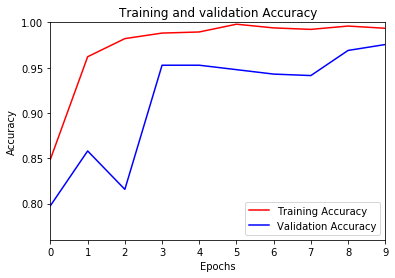

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
acc=History[0].history['acc']
val_acc=History[0].history['val_acc']
loss=History[0].history['loss']
val_loss=History[0].history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.760,1.00))
plt.xlim([0,9])
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

<Figure size 432x288 with 0 Axes>

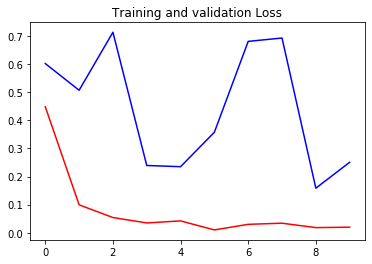

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title("Training and validation Loss")
plt.figure()

<Figure size 432x288 with 0 Axes>

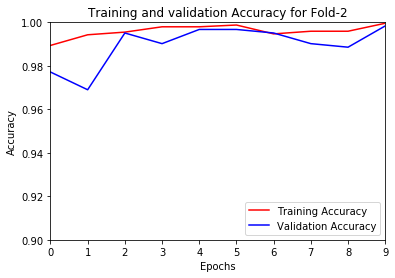

<Figure size 432x288 with 0 Axes>

In [0]:
acc=History[1].history['acc']
val_acc=History[1].history['val_acc']
loss=History[1].history['loss']
val_loss=History[1].history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.90,1.00))
plt.xlim([0,9])
plt.title("Training and validation Accuracy for Fold-2")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

<Figure size 432x288 with 0 Axes>

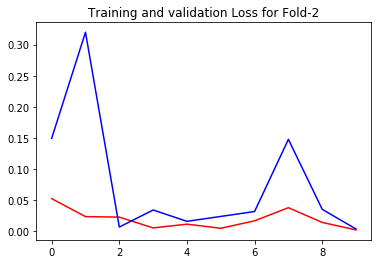

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title("Training and validation Loss for Fold-2")
plt.figure()

<Figure size 432x288 with 0 Axes>

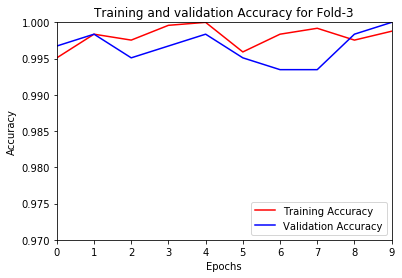

<Figure size 432x288 with 0 Axes>

In [0]:
acc=History[2].history['acc']
val_acc=History[2].history['val_acc']
loss=History[2].history['loss']
val_loss=History[2].history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.97,1.00))
plt.xlim([0,9])
plt.title("Training and validation Accuracy for Fold-3")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

<Figure size 432x288 with 0 Axes>

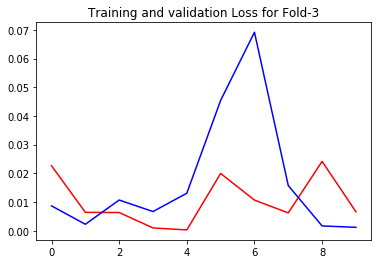

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title("Training and validation Loss for Fold-3")
plt.figure()

<Figure size 432x288 with 0 Axes>

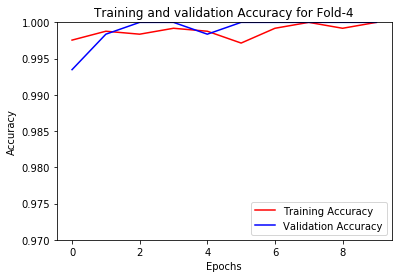

<Figure size 432x288 with 0 Axes>

In [0]:
acc=History[3].history['acc']
val_acc=History[3].history['val_acc']
loss=History[3].history['loss']
val_loss=History[3].history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.97,1.00))
plt.title("Training and validation Accuracy for Fold-4")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

<Figure size 432x288 with 0 Axes>

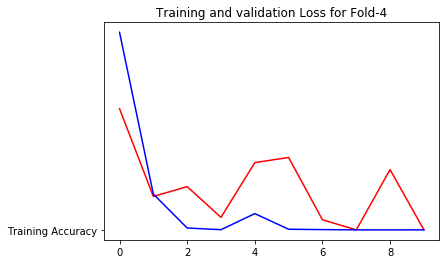

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs,loss,'r','Training Accuracy')
plt.plot(epochs,val_loss,'b','Training Accuracy')
plt.title("Training and validation Loss for Fold-4")
plt.figure()

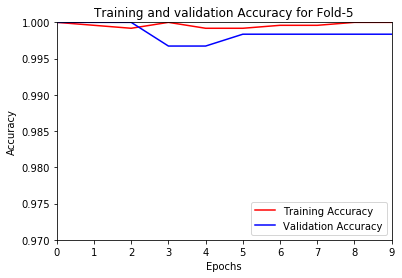

In [0]:
acc=History[4].history['acc']
val_acc=History[4].history['val_acc']
loss=History[4].history['loss']
val_loss=History[4].history['val_loss']

epochs=range(len(acc))
plt.figure()
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim([0.97,1.00])
plt.xlim([0,9])
plt.title("Training and validation Accuracy for Fold-5")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

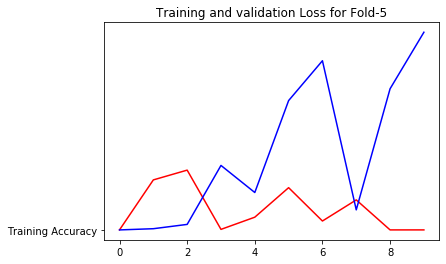

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs,loss,'r','Training Accuracy')
plt.plot(epochs,val_loss,'b','Training Accuracy')
plt.title("Training and validation Loss for Fold-5")
plt.figure()

In [0]:
y_predict=model.predict(X_dataset)

In [0]:
Y_predict=np.argmax(y_predict,axis=1)

In [0]:
#print(Y_predict)
Y_predict=np.reshape(Y_predict,(3064,1))
print(Y_predict)

[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
metrics=confusion_matrix(Y_dataset,Y_predict)
print(metrics)

[[ 708    0    0]
 [   1 1425    0]
 [   0    0  930]]


In [0]:
from sklearn.metrics import precision_score

In [0]:
prescore=precision_score(Y_dataset,Y_predict,average=None)


In [0]:
print(prescore)

[0.97091413 1.         0.99252935]


In [0]:
from sklearn.metrics import recall_score

In [0]:
recaller=recall_score(Y_dataset,Y_predict,average=None)

In [0]:
print(recaller)

[1.         0.99929874 1.        ]


In [0]:
from sklearn.metrics import f1_score

In [0]:
score=f1_score(Y_dataset,Y_predict,average=None)

In [0]:
print(score)

[0.99929428 0.99964925 1.        ]


In [0]:
#Printing ROC 
from sklearn.preprocessing import label_binarize

In [0]:
lb=label_binarize(Y_dataset,classes=[0,1,2])
print(lb)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]


In [0]:
lb1=label_binarize(Y_predict,classes=[0,1,2])
print(lb1)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]


In [0]:
from sklearn.metrics import auc,roc_curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(lb[:, i], lb1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

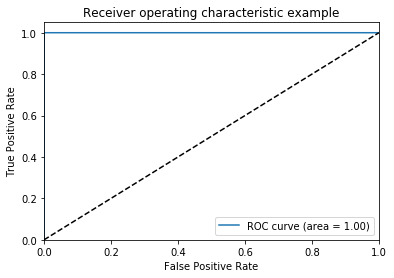

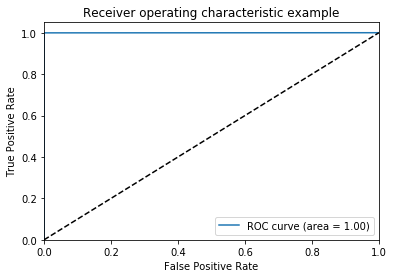

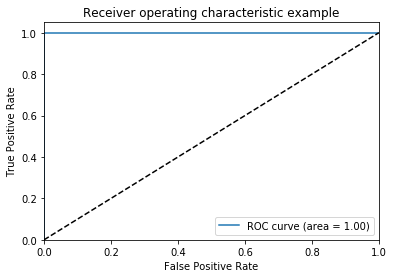

In [0]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()